## Multiple Linear Regression Model for a Bike Sharing Dataset

This dataset has bike rentals in 2011 and 2012 from Capital bikeshare. The dataset is described here:
http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset	

and is available (day.csv) for download from:
http://archive.ics.uci.edu/ml/machine-learning-databases/00275/

Author: Katherine Splett


In [1]:
# set up the pyspark environment
import os
import sys

spark_path = "C:\spark\spark-2.1.0-bin-hadoop2.7"

os.environ['SPARK_HOME'] = spark_path
os.environ['HADOOP_HOME'] = spark_path

sys.path.append(spark_path + "/bin")
sys.path.append(spark_path + "/python")
sys.path.append(spark_path + "/python/pyspark/")
sys.path.append(spark_path + "/python/lib")
sys.path.append(spark_path + "/python/lib/pyspark.zip")
sys.path.append(spark_path + "/python/lib/py4j-0.10.4-src.zip")

import pyspark
from pyspark import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.sql import SQLContext

# Stop Spark context started by default and start another Spark context
# Allows code to reexecute without error
# sc.stop()
sc = SparkContext("local", "test")

spark = SparkSession(sc)

import pyspark.sql
from pyspark.sql.functions import col, avg

# Profile data

Read the bike share dataset into a Pyspark data frame.

In [2]:
path = "C:\myClasses\INET4710_2017Spring\Labs\Lab5\Bike-Sharing-Dataset\\"
file = "day.csv"
df = spark.read.csv( ''.join([path, file]) ,header = True, inferSchema = True)
# Cache the dataset in memory the first time it is used
# Reread the dataset from memory instead of rereading from disk
df.cache()
df.printSchema()

root
 |-- instant: integer (nullable = true)
 |-- dteday: timestamp (nullable = true)
 |-- season: integer (nullable = true)
 |-- yr: integer (nullable = true)
 |-- mnth: integer (nullable = true)
 |-- holiday: integer (nullable = true)
 |-- weekday: integer (nullable = true)
 |-- workingday: integer (nullable = true)
 |-- weathersit: integer (nullable = true)
 |-- temp: double (nullable = true)
 |-- atemp: double (nullable = true)
 |-- hum: double (nullable = true)
 |-- windspeed: double (nullable = true)
 |-- casual: integer (nullable = true)
 |-- registered: integer (nullable = true)
 |-- cnt: integer (nullable = true)



In [3]:
print ("Dataset has %d rows." % df.count())

Dataset has 731 rows.


In [4]:
df = df.drop("dteday").drop("atemp")
df.take(3)

[Row(instant=1, season=1, yr=0, mnth=1, holiday=0, weekday=6, workingday=0, weathersit=2, temp=0.344167, hum=0.805833, windspeed=0.160446, casual=331, registered=654, cnt=985),
 Row(instant=2, season=1, yr=0, mnth=1, holiday=0, weekday=0, workingday=0, weathersit=2, temp=0.363478, hum=0.696087, windspeed=0.248539, casual=131, registered=670, cnt=801),
 Row(instant=3, season=1, yr=0, mnth=1, holiday=0, weekday=1, workingday=1, weathersit=1, temp=0.196364, hum=0.437273, windspeed=0.248309, casual=120, registered=1229, cnt=1349)]

In [5]:
df_var = df.select('workingday','casual','windspeed','hum','temp')
df_var.describe(['casual','windspeed','hum','temp']).show()

+-------+-----------------+-------------------+------------------+-------------------+
|summary|           casual|          windspeed|               hum|               temp|
+-------+-----------------+-------------------+------------------+-------------------+
|  count|              731|                731|               731|                731|
|   mean|848.1764705882352| 0.1904862116279068|0.6278940629274962|0.49538478850889184|
| stddev|686.6224882846551|0.07749787068166944| 0.142429095138354|0.18305099611148876|
|    min|                2|          0.0223917|               0.0|          0.0591304|
|    max|             3410|           0.507463|            0.9725|           0.861667|
+-------+-----------------+-------------------+------------------+-------------------+



In [6]:
# randomly select train (70%) and test (30%) datasets
train, test = df_var.randomSplit([0.7, 0.3])
type(train)

pyspark.sql.dataframe.DataFrame

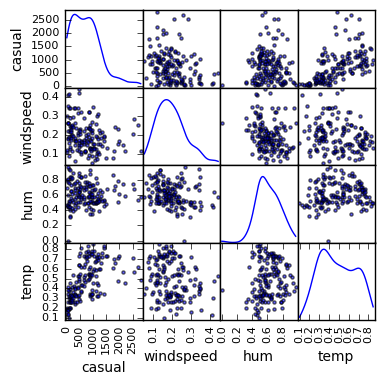

In [7]:
import numpy as np
from pandas.tools.plotting import scatter_matrix
import matplotlib.pyplot as plt

# sample 30% of the training observations without replacement for plotting purposes
sample_train = train.sample(False, 0.3)

# kde = kernel density estimate
pdf_sample = sample_train.select('casual','windspeed','hum','temp').toPandas()
fig = scatter_matrix(pdf_sample, alpha=0.6, figsize=(4, 4), diagonal='kde')
plt.show()

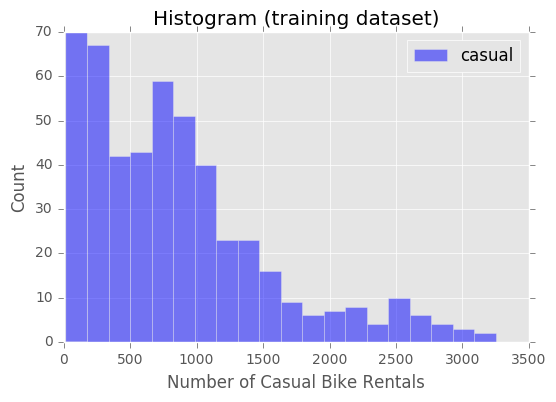

In [8]:
import matplotlib
matplotlib.style.use('ggplot')

h = train.select('casual').toPandas()
h.plot.hist(alpha=0.5, facecolor='blue', bins=20)
plt.xlabel('Number of Casual Bike Rentals')
plt.ylabel('Count')
plt.title('Histogram (training dataset)')
plt.show()

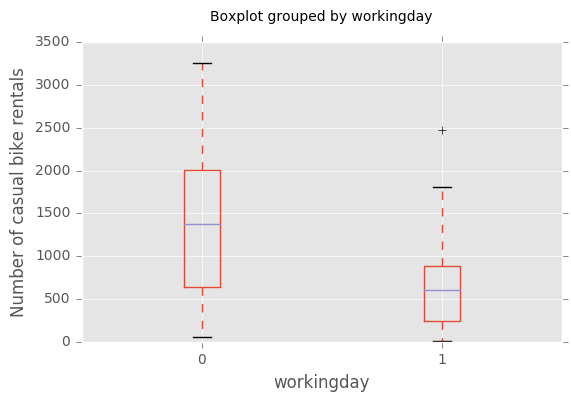

In [9]:
b = train.select('workingday', 'casual').toPandas()
bp = b.boxplot(column='casual', by='workingday', return_type='axes')
plt.ylabel('Number of casual bike rentals')
plt.title('')
plt.show()

# Multiple Linear Regression Model

Use sklearn.linear_model.LinearRegression  
LinearRegression requires Pandas data frame for X and Pandas series for the response value. 

No regularization is done for ordinary least squares 
Using Stochastic Gradient Descent 
No scaling done

References:
https://spark.apache.org/docs/latest/mllib-linear-methods.html
http://www.techpoweredmath.com/spark-dataframes-mllib-tutorial/

In [10]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
type(df)

pyspark.sql.dataframe.DataFrame

In [98]:
df_train   = train.select('casual','windspeed','hum','temp')
df_train_x = df_train.select('windspeed','hum','temp')
pd_train_x = df_train_x.toPandas()             # pandas.core.frame.DataFrame
pf_train_y = df_train.select('casual').toPandas()
series_y   = pf_train_y["casual"]

# pd_train_x.shape      # (493, 3)
# df_train_y.shape      # (493, 1)
lm = linear_model.LinearRegression()
lm.fit(pd_train_x, series_y)

print(pd_train_x.columns)
print('Coefficients: \n', lm.coef_)
print("\nMean squared error: %.2f"
      % np.mean((lm.predict(pd_train_x) - series_y) ** 2))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % lm.score(pd_train_x, series_y))

df_test_x = test.select('windspeed','hum','temp')
pd_test_x = df_test_x.toPandas()             # pandas.core.frame.DataFrame
pf_test_y = test.select('casual').toPandas()
test_y = pf_test_y["casual"]

pred_train = lm.predict(pd_train_x)
pred_test = lm.predict(pd_test_x)


Index(['windspeed', 'hum', 'temp'], dtype='object')
Coefficients: 
 [ -906.64345847  -759.1698667   1988.88972423]

Mean squared error: 317728.77
Variance score: 0.31


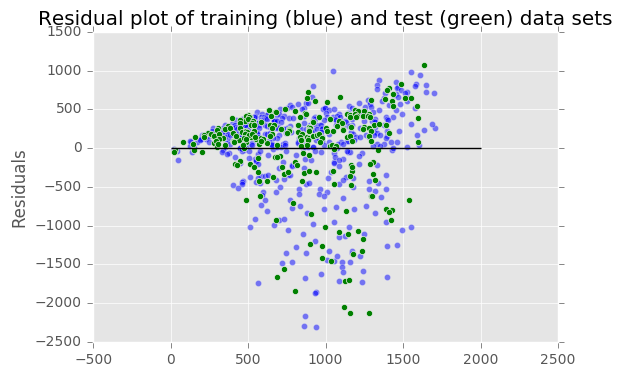

In [85]:
plt.scatter(lm.predict(pd_train_x), lm.predict(pd_train_x) - series_y, c = 'b', alpha=0.5)
plt.scatter(lm.predict(pd_test_x), lm.predict(pd_test_x) - test_y, c = 'g')
plt.hlines(y = 0, xmin = 0, xmax = 2000)
plt.title("Residual plot of training (blue) and test (green) data sets")
plt.ylabel("Residuals")
plt.show()

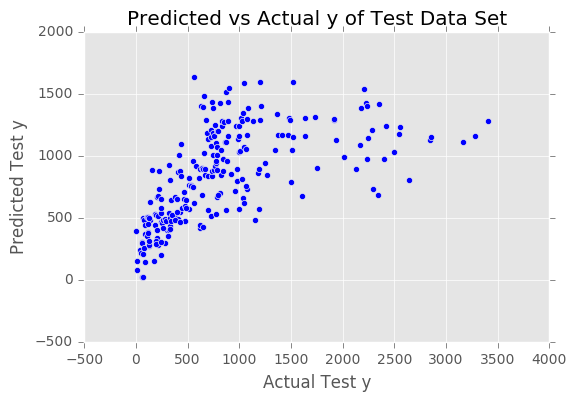

In [97]:
plt.scatter(test_y, pred_test)
plt.title("Predicted vs Actual y of Test Data Set")
plt.ylabel("Predicted Test y")
plt.xlabel("Actual Test y")
plt.show()